In [27]:
import sys
#sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")
sys.path.insert(0, r'/home/pirwin/Git/HelperPI')
import itertools
import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, classification_report
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [4]:
#sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\TAB_MODELING.sql")

In [5]:
#base, dtypesdf = helper.readData(sql)
#base = pd.read_csv(r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\tab_model.csv', parse_dates=['DATE_VALUE'])
base = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/tab_model.csv',parse_dates=['DATE_VALUE'])
base['DAYS_BTW_PURCH'] = base['DAYS_AS_CUSTOMER']/base['TOTAL_TRANSACTIONS']
dtypes = helper.getDtypes(base)

INFO:root:Getting data types...


                  Count     Column Type
0            DATE_VALUE  datetime64[ns]
1                RECORD          object
2            MEDHINC_CY         float64
3             MEDAGE_CY         float64
4            CLOSEST_BP         float64
5           CLOSEST_CAB         float64
6     MALES_IN_HOUSHOLD           int64
7   FEMALES_IN_HOUSHOLD           int64
8      REWARDS_CUSTOMER           int64
9      DAYS_AS_CUSTOMER           int64
10   TOTAL_TRANSACTIONS           int64
11     REW_TRANSACTIONS           int64
12          TOTAL_SPEND         float64
13  DAYS_SINCE_PURCHASE           int64
14     TARGET_VALUE12MO         float64
15  TARGET_PURCH_NEXT15           int64
16       DAYS_BTW_PURCH         float64


### Imputing missing then Splitting the data for train and test using helper application

In [6]:
collist = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_TRANSACTIONS','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE',
          'DAYS_BTW_PURCH']
X = base[collist]
y = base['TARGET_PURCH_NEXT15']


### Determination of missing values

In [7]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / X.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.01]

,column_name,missing_count,missing_ratio
0,MEDHINC_CY,3792,0.03792
1,MEDAGE_CY,3792,0.03792


MEDHINC_CY Coef: -0.01  pval:  0.1072
MEDAGE_CY Coef: 0.03  pval:  0.0000
CLOSEST_BP Coef: -0.01  pval:  0.0001
MALES_IN_HOUSHOLD Coef: 0.18  pval:  0.0000
FEMALES_IN_HOUSHOLD Coef: 0.04  pval:  0.0000
REWARDS_CUSTOMER Coef: 0.34  pval:  0.0000
DAYS_AS_CUSTOMER Coef: 0.06  pval:  0.0000
TOTAL_TRANSACTIONS Coef: 0.30  pval:  0.0000
REW_TRANSACTIONS Coef: 0.27  pval:  0.0000
TOTAL_SPEND Coef: 0.36  pval:  0.0000
DAYS_SINCE_PURCHASE Coef: -0.38  pval:  0.0000
DAYS_BTW_PURCH Coef: -0.34  pval:  0.0000


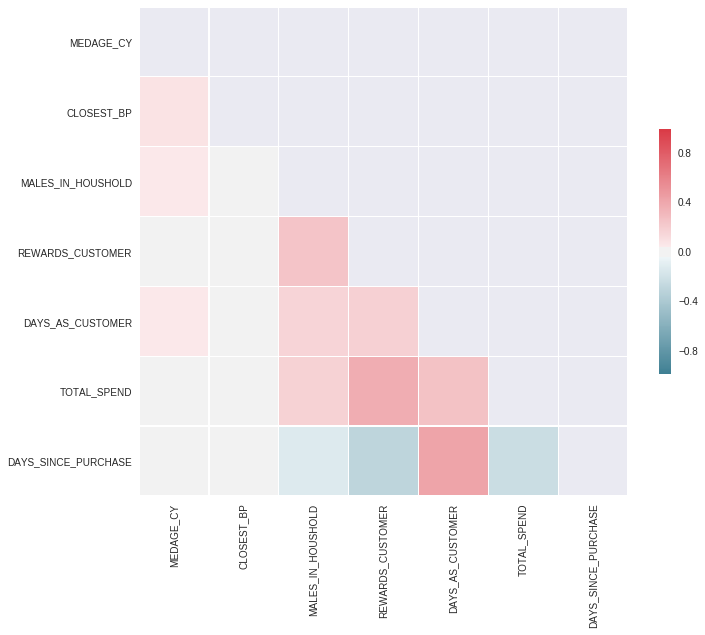

In [8]:

imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X)
imputed_data = pd.DataFrame(imr.transform(X.values), columns = collist)

for var in collist:
    coef, pval = stats.pearsonr(imputed_data[var].as_matrix(), y.as_matrix())
    
    print(var + ' Coef: %.2f  pval:  %.4f' % (coef, pval))


collist2 = ['MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_SPEND','DAYS_SINCE_PURCHASE']

imputed_data2 = imputed_data[collist2]
    
corr = imputed_data2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


    



In [9]:
train_X, test_X, train_y, test_y = helper.splitData2(imputed_data2, y, 0.3)

train_X = pd.DataFrame(train_X, columns=collist2)
test_X = pd.DataFrame(test_X, columns=collist2)

In [10]:
train_X.head()

,MEDAGE_CY,CLOSEST_BP,MALES_IN_HOUSHOLD,REWARDS_CUSTOMER,DAYS_AS_CUSTOMER,TOTAL_SPEND,DAYS_SINCE_PURCHASE
42865,32.0,5.93,1.0,0.0,1634.0,299.99,571.0
91446,37.0,29.71,1.0,1.0,3821.0,3121.45,205.0
66374,33.0,13.47,1.0,1.0,351.0,192.85,66.0
79106,34.0,19.09,0.0,0.0,3195.0,155.81,2063.0
13404,39.0,52.51,1.0,1.0,3383.0,1060.54,649.0


In [11]:
#sns.pairplot(train_X)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

In [12]:

stdsc = StandardScaler()
train_X_std = pd.DataFrame(stdsc.fit_transform(train_X), columns=collist2)
test_X_std = pd.DataFrame(stdsc.fit_transform(test_X), columns=collist2)

sm = SMOTE(random_state=123, ratio=1.0)
train_X_std_res, train_y_res = sm.fit_sample(train_X_std, train_y)

#train_X_std_res = pd.DataFrame(train_X_std_res, columns = collist2)
#train_y_res = pd.DataFrame(train_y_res)

#sns.pairplot(train_X_std)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
print(sum(train_y), len(train_y))
print()

13266 70000



In [14]:
sum(test_y), len(test_y)

(5663, 30000)

 1) DAYS_SINCE_PURCHASE            0.338979
 2) TOTAL_SPEND                    0.217151
 3) DAYS_AS_CUSTOMER               0.133841
 4) CLOSEST_BP                     0.119028
 5) MEDAGE_CY                      0.102959
 6) REWARDS_CUSTOMER               0.064600
 7) MALES_IN_HOUSHOLD              0.023442


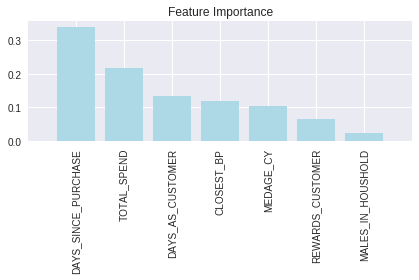

In [21]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = np.asarray(collist2)

forests = RandomForestClassifier(n_estimators=300,
                                random_state=0,
                                n_jobs=-1)
forests.fit(train_X_std_res, train_y_res)
importances = forests.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train_X_std_res.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],
                                      importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(train_X_std_res.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(train_X_std_res.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, train_X_std_res.shape[1]])
plt.tight_layout()
plt.show()

### Parameter Tuning Version

In [22]:
def modelfit(alg, dtrain, dlabels, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=dlabels.values, feature_names = feature_names)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain, dlabels, eval_metric='auc')

    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dlabels.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dlabels.values, dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    
    


Model Report
Accuracy : 0.8702
AUC Score (Train): 0.888145


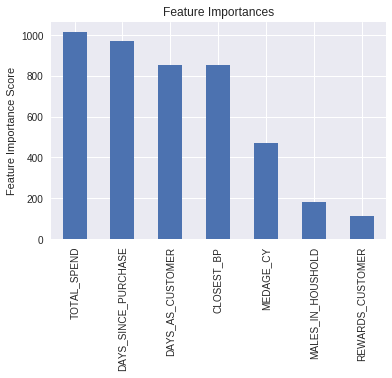

In [25]:
xgb1 = xgb.XGBClassifier(
    learning_rate = 0.07,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb1, train_X_std, train_y, collist2)

In [26]:
auc_weighted = make_scorer(roc_auc_score, average='weighted')
auc_weighted

make_scorer(roc_auc_score, average=weighted)

In [27]:
param_test1 = {
    'max_depth':list(range(3,12,2)),
    'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test1, scoring=auc_weighted, iid=False, cv=5)

gsearch1.fit(train_X_std_res, train_y_res)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.82882, std: 0.02583, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: 0.82867, std: 0.02572, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: 0.82854, std: 0.02577, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: 0.84933, std: 0.03858, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: 0.84964, std: 0.03840, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: 0.84929, std: 0.03892, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: 0.85801, std: 0.04460, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: 0.85716, std: 0.04428, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: 0.85721, std: 0.04409, params: {'min_child_weight': 5, 'max_depth': 7},
  mean: 0.86387, std: 0.04740, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: 0.86321, std: 0.04671, params: {'min_child_weight': 3, 'max_depth': 9},
  mean: 0.86186, std: 0.04743, params: {'min_child_weight': 5, 'max_depth': 9},
  mean: 0.86880, std: 0.04954, params: {

In [32]:
#max_depth = 11
#min_child_weight = 1


param_test2 = {
    'max_depth': [9, 10,11,12],
    'min_child_weight':[0,1,2]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=11,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test2, scoring=auc_weighted, iid=False, cv=5)

gsearch2.fit(train_X_std_res, train_y_res)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86371, std: 0.04778, params: {'min_child_weight': 0, 'max_depth': 9},
  mean: 0.86387, std: 0.04740, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: 0.86326, std: 0.04760, params: {'min_child_weight': 2, 'max_depth': 9},
  mean: 0.86682, std: 0.04827, params: {'min_child_weight': 0, 'max_depth': 10},
  mean: 0.86644, std: 0.04772, params: {'min_child_weight': 1, 'max_depth': 10},
  mean: 0.86566, std: 0.04869, params: {'min_child_weight': 2, 'max_depth': 10},
  mean: 0.86892, std: 0.04861, params: {'min_child_weight': 0, 'max_depth': 11},
  mean: 0.86880, std: 0.04954, params: {'min_child_weight': 1, 'max_depth': 11},
  mean: 0.86775, std: 0.04906, params: {'min_child_weight': 2, 'max_depth': 11},
  mean: 0.87118, std: 0.04826, params: {'min_child_weight': 0, 'max_depth': 12},
  mean: 0.87006, std: 0.04958, params: {'min_child_weight': 1, 'max_depth': 12},
  mean: 0.86897, std: 0.05030, params: {'min_child_weight': 2, 'max_depth': 12}],
 {'max_depth': 12, 'min_child_

In [33]:
#max_depth = 12
#min_child_weight = 0


param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
     min_child_weight=0, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test3, scoring=auc_weighted, iid=False, cv=5)

gsearch3.fit(train_X_std_res, train_y_res)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87118, std: 0.04826, params: {'gamma': 0.0},
  mean: 0.87129, std: 0.04914, params: {'gamma': 0.1},
  mean: 0.87065, std: 0.04847, params: {'gamma': 0.2},
  mean: 0.87099, std: 0.04936, params: {'gamma': 0.3},
  mean: 0.87139, std: 0.04972, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.87139156982300148)

In [34]:
#max_depth = 12
#min_child_weight = 0


param_test4 = {
    'gamma':[0.35, 0.4, 0.45]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
     min_child_weight=0, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test4, scoring=auc_weighted, iid=False, cv=5)

gsearch4.fit(train_X_std_res, train_y_res)

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87092, std: 0.04919, params: {'gamma': 0.35},
  mean: 0.87139, std: 0.04972, params: {'gamma': 0.4},
  mean: 0.87125, std: 0.04918, params: {'gamma': 0.45}],
 {'gamma': 0.4},
 0.87139156982300148)

In [35]:
#max_depth = 12
#min_child_weight = 0
#gamma = 0.4

param_test4 = {
     'subsample':[i/10.0 for i in range(5,11)],
     'colsample_bytree':[i/10.0 for i in range(5,11)],
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
     min_child_weight=0, gamma=0.4, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test4, scoring=auc_weighted, iid=False, cv=5)

gsearch4.fit(train_X_std_res, train_y_res)

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86458, std: 0.05116, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: 0.86505, std: 0.05201, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.86681, std: 0.05185, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: 0.86704, std: 0.05163, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: 0.86744, std: 0.05230, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: 0.86753, std: 0.05300, params: {'colsample_bytree': 0.5, 'subsample': 1.0},
  mean: 0.86911, std: 0.04760, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: 0.87114, std: 0.04859, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.87139, std: 0.04972, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.87200, std: 0.04900, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.87264, std: 0.04920, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.87300, std: 0.05026, params: {'colsample_bytree': 0.6, 'subsample'

In [36]:
#max_depth = 12
#min_child_weight = 0
#gamma = 0.4
#subsample = 0.8
#colsample_bytree = 1.0

param_test5 = {
     'subsample':[0.75, 0.8, 0.85],
     'colsample_bytree':[0.9, 0.95, 1.0],
}

gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
     min_child_weight=0, gamma=0.4, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test5, scoring=auc_weighted, iid=False, cv=5)

gsearch5.fit(train_X_std_res, train_y_res)

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87618, std: 0.04704, params: {'colsample_bytree': 0.9, 'subsample': 0.75},
  mean: 0.87612, std: 0.04675, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: 0.87711, std: 0.04677, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: 0.87618, std: 0.04704, params: {'colsample_bytree': 0.95, 'subsample': 0.75},
  mean: 0.87612, std: 0.04675, params: {'colsample_bytree': 0.95, 'subsample': 0.8},
  mean: 0.87711, std: 0.04677, params: {'colsample_bytree': 0.95, 'subsample': 0.85},
  mean: 0.87744, std: 0.04483, params: {'colsample_bytree': 1.0, 'subsample': 0.75},
  mean: 0.87801, std: 0.04597, params: {'colsample_bytree': 1.0, 'subsample': 0.8},
  mean: 0.87754, std: 0.04541, params: {'colsample_bytree': 1.0, 'subsample': 0.85}],
 {'colsample_bytree': 1.0, 'subsample': 0.8},
 0.87801014628656271)

In [37]:
#max_depth = 12
#min_child_weight = 0
#gamma = 0.4
#subsample = 0.8
#colsample_bytree = 1.0

param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
     min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=1.0,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test6, scoring=auc_weighted, iid=False, cv=5)

gsearch6.fit(train_X_std_res, train_y_res)

gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87804, std: 0.04590, params: {'reg_alpha': 1e-05},
  mean: 0.87822, std: 0.04614, params: {'reg_alpha': 0.01},
  mean: 0.87745, std: 0.04644, params: {'reg_alpha': 0.1},
  mean: 0.87702, std: 0.04644, params: {'reg_alpha': 1},
  mean: 0.83490, std: 0.03181, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.87822164661579971)

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirwin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : 0.9429
AUC Score (Train): 0.988900


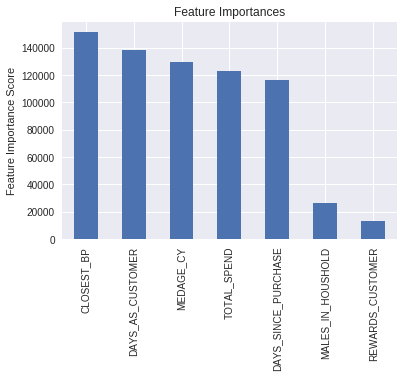

In [39]:
xgb3 = xgb.XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 1000,
    max_depth = 12,
    min_child_weight = 0,
    gamma = 0.4,
    subsample = 0.9,
    colsample_bytree = 1.0,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    reg_alpha=0.01,
    seed = 27)

modelfit(xgb3, pd.DataFrame(train_X_std_res, columns=collist2), pd.DataFrame(train_y_res), collist2)

In [21]:

tuned_model = xgb.XGBClassifier(learning_rate = 0.01,
                        n_estimators = 1000,
                        max_depth = 12,
                        min_child_weight = 0,
                        gamma = 0.4,
                        subsample = 0.9,
                        colsample_bytree = 1.0,
                        objective = 'binary:logistic',
                        scale_pos_weight = 1,
                        reg_alpha= 0.01,
                        seed = 27)
xgbmodel = tuned_model.fit(train_X_std_res, train_y_res, 
                 eval_set=[(train_X_std_res, train_y_res), (test_X_std.values, test_y)], 
                 eval_metric='auc',
                 early_stopping_rounds=100,                 
                 verbose=True)

#fig, ax = plt.subplots(figsize=(12,18))
#xgb.plot_importance(xgbmodel, height=0.8, ax=ax)
#plt.show()

[0]	validation_0-auc:0.909785	validation_1-auc:0.829908
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.915809	validation_1-auc:0.839568
[2]	validation_0-auc:0.918009	validation_1-auc:0.843355
[3]	validation_0-auc:0.919976	validation_1-auc:0.846606
[4]	validation_0-auc:0.920609	validation_1-auc:0.84767
[5]	validation_0-auc:0.921588	validation_1-auc:0.848454
[6]	validation_0-auc:0.922108	validation_1-auc:0.849572
[7]	validation_0-auc:0.923017	validation_1-auc:0.849019
[8]	validation_0-auc:0.923604	validation_1-auc:0.850445
[9]	validation_0-auc:0.923839	validation_1-auc:0.850271
[10]	validation_0-auc:0.924321	validation_1-auc:0.850814
[11]	validation_0-auc:0.924399	validation_1-auc:0.851254
[12]	validation_0-auc:0.924547	validation_1-auc:0.851349
[13]	validation_0-auc:0.92489	validation_1-auc:0.8517
[14]	validation_0-auc:0.925225	validation_1-auc:0.851852
[

Accuracy: 77.65%


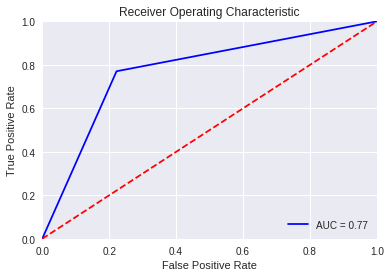

In [22]:
pred_y = xgbmodel.predict(test_X_std.values)

accuracy = accuracy_score(test_y, pred_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, pred_y)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###  Alternate Parameter tuning - only for fast running algorithms

In [15]:

tuned_parameters = [{
    'C': [1000, 100, 10, 1, .1, .01, .001],
    'dual': [False]
}]

scores = ['roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_X_std)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'C': 1000, 'dual': False}

Grid scores on development set:

0.856 (+/-0.004) for {'C': 1000, 'dual': False}
0.856 (+/-0.004) for {'C': 100, 'dual': False}
0.856 (+/-0.004) for {'C': 10, 'dual': False}
0.856 (+/-0.004) for {'C': 1, 'dual': False}
0.856 (+/-0.004) for {'C': 0.1, 'dual': False}
0.856 (+/-0.004) for {'C': 0.01, 'dual': False}
0.856 (+/-0.004) for {'C': 0.001, 'dual': False}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.94      0.76      0.84     24337
          1       0.44      0.80      0.57      5663

avg / total       0.85      0.77      0.79     30000




             precision    recall  f1-score   support

          0       0.94      0.77      0.85     24337
          1       0.44      0.79      0.57      5663

avg / total       0.85      0.77      0.79     30000

Accuracy: 77.33%


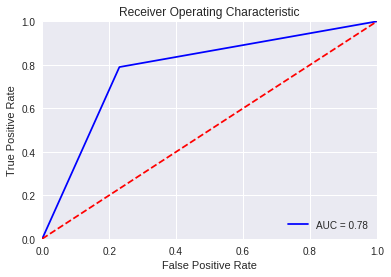

In [16]:
svm = LinearSVC(C=1000,dual=False)

clf = CalibratedClassifierCV(svm, method='sigmoid', cv=5)

svcmodel = clf.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, svcmodel.predict(test_X_std)))


# evaluate predictions
accuracy = accuracy_score(test_y, svcmodel.predict(test_X_std))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, svcmodel.predict(test_X_std))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
tuned_parameters = [{
    'C': [1000, 100, 10, 1, .1, .01, .001],
    'dual':[False],
    'solver': ['liblinear','saga']
}]

scores = ['recall_weighted', 'roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_X_std)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall_weighted

Best parameters set found on development set:

{'C': 100, 'dual': False, 'solver': 'saga'}

Grid scores on development set:

0.785 (+/-0.005) for {'C': 1000, 'dual': False, 'solver': 'liblinear'}
0.785 (+/-0.005) for {'C': 1000, 'dual': False, 'solver': 'saga'}
0.785 (+/-0.005) for {'C': 100, 'dual': False, 'solver': 'liblinear'}
0.785 (+/-0.005) for {'C': 100, 'dual': False, 'solver': 'saga'}
0.785 (+/-0.005) for {'C': 10, 'dual': False, 'solver': 'liblinear'}
0.785 (+/-0.005) for {'C': 10, 'dual': False, 'solver': 'saga'}
0.785 (+/-0.005) for {'C': 1, 'dual': False, 'solver': 'liblinear'}
0.785 (+/-0.005) for {'C': 1, 'dual': False, 'solver': 'saga'}
0.785 (+/-0.005) for {'C': 0.1, 'dual': False, 'solver': 'liblinear'}
0.785 (+/-0.005) for {'C': 0.1, 'dual': False, 'solver': 'saga'}
0.785 (+/-0.005) for {'C': 0.01, 'dual': False, 'solver': 'liblinear'}
0.785 (+/-0.005) for {'C': 0.01, 'dual': False, 'solver': 'saga'}
0.782 (+/-0.005) for

             precision    recall  f1-score   support

          0       0.94      0.77      0.85     24337
          1       0.44      0.81      0.57      5663

avg / total       0.85      0.77      0.79     30000

Accuracy: 77.31%


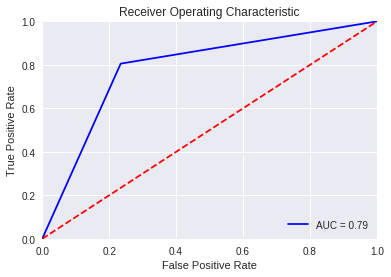

In [19]:

log = LogisticRegression(C=100,dual=False, solver='saga')

logmodel = log.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, logmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y,logmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, logmodel.predict(test_X_std.values))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
tuned_parameters = [{
    'loss':['hinge','log'],
    
}]

scores = ['recall_weighted', 'roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SGDClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_X_std)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall_weighted



/home/pirwin/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best parameters set found on development set:

{'loss': 'log'}

Grid scores on development set:

0.771 (+/-0.009) for {'loss': 'hinge'}
0.781 (+/-0.006) for {'loss': 'log'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.94      0.77      0.84     24337
          1       0.44      0.78      0.56      5663

avg / total       0.84      0.77      0.79     30000


# Tuning hyper-parameters for roc_auc



/home/pirwin/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best parameters set found on development set:

{'loss': 'log'}

Grid scores on development set:

0.855 (+/-0.009) for {'loss': 'hinge'}
0.859 (+/-0.005) for {'loss': 'log'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.95      0.71      0.81     24337
          1       0.40      0.83      0.54      5663

avg / total       0.84      0.74      0.76     30000




/home/pirwin/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


             precision    recall  f1-score   support

          0       0.95      0.73      0.82     24337
          1       0.41      0.83      0.55      5663

avg / total       0.85      0.75      0.77     30000

Accuracy: 77.31%


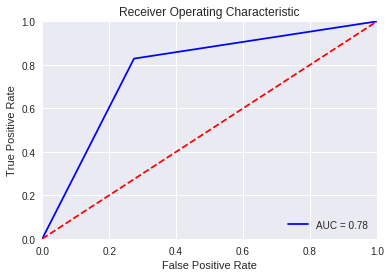

In [29]:

sgd =SGDClassifier(loss='log')

sgdmodel = sgd.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, sgdmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y,logmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, sgdmodel.predict(test_X_std.values))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
sgdpred = sgdmodel.predict(train_X_std_res)
xgbpred = xgbmodel.predict(train_X_std_res)
logpred = logmodel.predict(train_X_std_res)
resarray = np.array([train_y_res, xgbpred, sgdpred, logpred], np.int32)

sgd_test = sgdmodel.predict(test_X_std.values)
xgb_test = xgbmodel.predict(test_X_std.values)
log_test = logmodel.predict(test_X_std.values)
res_test = np.array([test_y, xgb_test, sgd_test, log_test], np.int32)

result = pd.DataFrame(resarray.transpose(), columns = ['true_y','xgbpred', 'sgdpred', 'logpred'])
result_test = pd.DataFrame(res_test.transpose(), columns = ['true_y','xgbpred', 'sgdpred', 'logpred'])
len(result), len(result_test)

(113468, 30000)

In [31]:
result_test.corr()

,true_y,xgbpred,sgdpred,logpred
true_y,1.000000,0.458058,0.447238,0.470995
xgbpred,0.458058,1.000000,0.685953,0.723657
sgdpred,0.447238,0.685953,1.000000,0.876232
logpred,0.470995,0.723657,0.876232,1.000000


In [193]:
len(svcpred), len(xgbpred), len(logpred), len(train_y_res)


(81084, 81084, 81084, 81084)

In [196]:
len(svc_test), len(xgb_test), len(log_test), len(test_y)

(50000, 50000, 50000, 50000)

In [34]:
ensemble = LogisticRegression(C=1, dual=False, solver='saga')
ensemble.fit(result[['sgdpred','xgbpred','logpred']].values, result[['true_y']].values)



/home/pirwin/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [200]:
result.corr()

,true_y,svcpred,xgbpred,logpred
true_y,1.000000,0.571013,0.713594,0.580690
svcpred,0.571013,1.000000,0.784586,0.947088
xgbpred,0.713594,0.784586,1.000000,0.806292
logpred,0.580690,0.947088,0.806292,1.000000


Accuracy: 77.65%
             precision    recall  f1-score   support

          0       0.94      0.78      0.85     24337
          1       0.45      0.77      0.57      5663

avg / total       0.84      0.78      0.80     30000



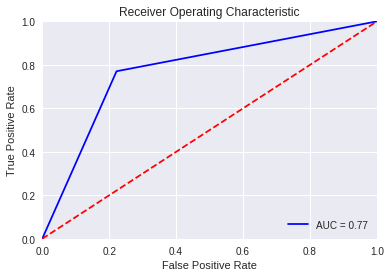

In [35]:
# evaluate predictions
accuracy = accuracy_score(result_test['true_y'].values, ensemble.predict(result_test[['sgdpred','xgbpred','logpred']].values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

print(classification_report(result_test['true_y'].values, ensemble.predict(result_test[['sgdpred','xgbpred','logpred']].values)))

fpr, tpr, _ = roc_curve(result_test['true_y'].values, ensemble.predict(result_test[['sgdpred','xgbpred','logpred']].values))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [203]:
confusion_matrix(result_test['true_y'].values, ensemble.predict(result_test[['svcpred','xgbpred','logpred']].values))


array([[31603,  8926],
       [ 2091,  7380]])

In [361]:
joblib.dump(svcmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodelsvc.pkl')
joblib.dump(xgbmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodelxgb.pkl')
joblib.dump(logmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodellog.pkl')
joblib.dump(ensemble, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodelensemble.pkl')
joblib.dump(imr, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodel_impute.pkl')

['C:\\users\\pairwin\\Documents\\GitHub\\IPy_Notebooks\\Analyses\\tabmodel_impute.pkl']

In [36]:
def decide(prob):
    if prob >= .5:
        return 1
    else:
        return 0

In [43]:
np.random.seed(0)

n_folds = 10
verbose = True
shuffle = False

X = X[collist2]

X2, hold_X, y2, hold_y = helper.splitData2(X.values, np.array(y), 0.2)


imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X2)
X_imp = pd.DataFrame(imr.transform(X2), columns = collist2)
hold_X_imp = pd.DataFrame(imr.transform(hold_X), columns = collist2)


X_scaled = stdsc.fit_transform(X_imp)
hold_X_scaled = stdsc.fit_transform(hold_X_imp)



sm = SMOTE(random_state=123, ratio=1.0)
X3, y3 = sm.fit_sample(X_scaled, y2)


skf = StratifiedKFold(n_folds)
print(len(X3), len(hold_X_scaled), len(y3), len(hold_y))
print(type(X3), type(hold_X_scaled), type(y3), type(hold_y))

/home/pirwin/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


129628 20000 129628 20000
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [44]:
svm = LinearSVC(C=.1,dual=False)

clfs = [KNeighborsClassifier(10),
        #GaussianNB(),
        #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        #RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        #ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        xgb.XGBClassifier(learning_rate = 0.01,
                        n_estimators = 1000,
                        max_depth = 12,
                        min_child_weight = 0,
                        gamma = 0.4,
                        subsample = 0.9,
                        colsample_bytree = 1.0,
                        objective = 'binary:logistic',
                        scale_pos_weight = 1,
                        reg_alpha= 0.01,
                        seed = 27),
        SGDClassifier(loss='log'),
        #MLPClassifier(alpha=1),
        #CalibratedClassifierCV(svm, cv=3, method='sigmoid')]
        LogisticRegression(C=100, dual=False, solver='saga')]


/home/pirwin/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [45]:
dataset_blend_train = np.zeros((X3.shape[0], len(clfs)))
dataset_blend_test = np.zeros((hold_X_scaled.shape[0], len(clfs)))
dataset_blend_train.shape, dataset_blend_test.shape

((129628, 6), (20000, 6))

In [47]:
for j, clf in enumerate(clfs):
    print(j, clf)
    dataset_blend_test_j = np.zeros((hold_X_scaled.shape[0], skf.get_n_splits()))
    fold = 0
    for train, test in skf.split(X3, y3):        
        print("Fold: " + str(fold))
        X_train = X3[train]
        y_train = y3[train]
        X_test = X3[test]
        y_test = y3[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, fold] = clf.predict_proba(hold_X_scaled)[:, 1]
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
        fold += 1
        

        
    print()
    print("Blending.")
    clf = LogisticRegression(solver='saga')
    clf.fit(dataset_blend_train, y3)
    y_submission = clf.predict_proba(dataset_blend_test)[:, 1]
    
    accuracy = accuracy_score(hold_y, np.array([decide(yi) for yi in y_submission]))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(classification_report(hold_y, np.array([decide(yi) for yi in y_submission])))
    print()
    print()

0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9

Blending.
Accuracy: 79.26%
             precision    recall  f1-score   support

          0       0.92      0.82      0.86     16257
          1       0.46      0.69      0.55      3743

avg / total       0.83      0.79      0.81     20000



1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9

Bl

Accuracy: 65.07%
             precision    recall  f1-score   support

          0       0.94      0.61      0.74     16257
          1       0.33      0.84      0.47      3743

avg / total       0.83      0.65      0.69     20000



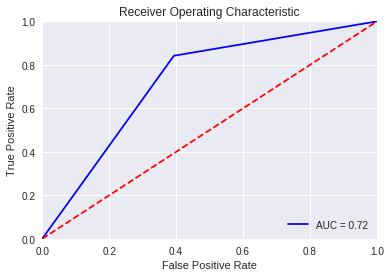

In [48]:
accuracy = accuracy_score(hold_y, np.array([decide(yi) for yi in y_submission]))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(hold_y, np.array([decide(yi) for yi in y_submission])))

fpr, tpr, _ = roc_curve(hold_y, np.array([decide(yi) for yi in y_submission]))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [ ]:
df = df[df['CLOSEST_CAB'] !=  'NaN' ]